In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import xgboost as xgb

In [60]:
# DATA_PATH = '../data/training/final/travel_ml.csv'
DATA_PATH = '../data/training/final/travel_insight_pruned.csv'
# VAL_DATA_PATH = '../data/validation/final/travel_ml.csv'
travel = pd.read_csv(DATA_PATH)
# travel_val = pd.read_csv(VAL_DATA_PATH)
travel.head()

,TRAVEL_ID,TRAVEL_LENGTH,activity_payment_sum,visit_move_cnt,IS_FAILED_TRIP,TRAVEL_SEASON,TRAVEL_SEASON_encoded,activity_type_1,activity_type_2,activity_type_3,...,activity_payment_sum_per_day,activity_type_1_per_day,activity_type_2_per_day,activity_type_3_per_day,activity_type_4_per_day,activity_type_5_per_day,activity_type_6_per_day,activity_type_7_per_day,activity_type_99_per_day,activity_history_rows_per_day
0,a_a014262,2,0.170515,5,1,가을,2,2,1,2,...,0.413794,1.00,0.5,1.00,0.0,0.00,0.00,0.0,0.0,2.5
1,a_a006728,2,-0.202802,5,0,가을,2,2,3,0,...,-0.153923,1.00,1.5,0.00,1.0,1.50,0.00,0.0,0.0,5.0
2,a_a015745,4,-0.242098,19,0,가을,2,5,2,3,...,-0.355612,1.25,0.5,0.75,2.5,0.25,0.25,0.0,0.0,5.5
3,a_a010544,2,-0.134033,9,1,가을,2,5,3,0,...,-0.049344,2.50,1.5,0.00,0.5,0.50,0.00,0.0,0.0,5.0
4,a_a012058,2,0.082098,5,1,가을,2,2,1,1,...,0.279335,1.00,0.5,0.50,1.0,1.00,0.00,0.0,0.0,4.0


In [ ]:
# 학습에 사용할 피처값 선언
BINARY_CLASSIFICATION_TARGET = 'IS_FAILED_TRIP'

BINARY_CLASSIFICATION_FEATURES = [
    'TRAVEL_LENGTH',
    'activity_payment_sum',
    'visit_move_cnt',
    # 'TRAVEL_SEASON',
    'TRAVEL_SEASON_encoded',
    'activity_type_1',
    'activity_type_2',
    'activity_type_3',
    'activity_type_4',
    'activity_type_5',
    'activity_type_6',
    'activity_type_7',
    'activity_type_99',
    'activity_history_rows',
    # 'activity_type_catboost',
    'visit_move_cnt_per_day',
    'activity_payment_sum_per_day',
    'activity_type_1_per_day',
    'activity_type_2_per_day',
    'activity_type_3_per_day',
    'activity_type_4_per_day',
    'activity_type_5_per_day',
    'activity_type_6_per_day',
    'activity_type_7_per_day',
    'activity_type_99_per_day',
    'activity_history_rows_per_day'
]

In [62]:
# 데이터 선언
X = travel[BINARY_CLASSIFICATION_FEATURES]
y = travel[BINARY_CLASSIFICATION_TARGET]

In [63]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3
)

In [64]:
# 불균형 진단 및 임계값 튜닝 설정
from collections import Counter

THRESHOLD_TUNING = 'f1'           # 'f1'|'f05'|'precision_at'|'none'
TARGET_PRECISION = 0.80           # precision_at 모드에서 사용

ctr = Counter(y_train)
n0, n1 = ctr.get(0, 0), ctr.get(1, 0)
pos_weight = (n0 / max(n1, 1)) if n1 else 1.0
print(f'Train class distribution -> 0: {n0}, 1: {n1} | scale_pos_weight={pos_weight:.3f}')


Train class distribution -> 0: 2878, 1: 1153 | scale_pos_weight=2.496


In [65]:
# Hyperparameter 최적화를 위해 Optuna
import optuna
# Optuna를 사용한 Hyperparameter 최적화
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
import xgboost as xgb
import numpy as np

# 1. Objective 함수 정의
# Optuna는 이 함수를 호출하여 각기 다른 하이퍼파라미터 조합으로 모델을 평가합니다.
# 이 함수의 반환값(성능 점수)을 최대화하는 하이퍼파라미터를 찾게 됩니다.
def objective(trial):
    """
    Optuna가 최적의 하이퍼파라미터를 찾기 위해 사용하는 함수입니다.
    trial 객체를 통해 탐색할 하이퍼파라미터의 범위와 종류를 지정합니다.
    """
    # 클래스 불균형 비율(양성:실패) 보정
    pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    
    # 하이퍼파라미터 탐색 공간을 정의합니다.
    # trial.suggest_... API를 사용하여 각 파라미터의 탐색 범위와 타입을 지정합니다.
    # 과적합을 줄이기 위해 탐색 범위를 보수적으로 조정
    param = {
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': pos_weight,
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    # 모델 생성
    model = XGBClassifier(**param)

    # 교차 검증(Cross-validation)을 통해 모델의 성능을 안정적으로 평가합니다.
    # 데이터를 여러 번 나누어 학습하고 평가하여 일반화 성능을 측정합니다.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = []
    # K-fold 교차 검증 수행
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # 조기 종료를 시도하되, 호환성 문제 시 안전하게 폴백
        try:
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                eval_metric='aucpr',
                verbose=False,
                early_stopping_rounds=50
            )
        except Exception as e:
            # 호환성 이슈 발생 시: 조기 종료 없이 학습
            model.fit(X_train_fold, y_train_fold)
        
        # 예측 확률 계산 및 성능 평가 (PR-AUC)
        preds = model.predict_proba(X_val_fold)[:, 1]
        pr_auc = average_precision_score(y_val_fold, preds)
        scores.append(pr_auc)

    # 교차 검증 점수들의 평균을 반환합니다. Optuna는 이 점수를 최대화하는 방향으로 탐색을 진행합니다.
    return np.mean(scores)

# 2. Study 생성 및 최적화 실행
# 'direction'을 'maximize'로 설정하여 objective 함수가 반환하는 점수가 높은 쪽으로 최적화를 진행합니다.
print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='maximize', study_name='xgb_optimization')

# 'n_trials'는 하이퍼파라미터 조합을 몇 번이나 시도해볼지 결정하는 값입니다.
study.optimize(objective, n_trials=40) # 기존 RandomizedSearchCV와 유사하게 40회 시도

# 3. 최적화 결과 확인
print("Optimization finished.")
print('Best trial:')
best_trial = study.best_trial

print(f'  Value (PR-AUC): {best_trial.value:.4f}')
print('  Best Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# 4. 최적의 하이퍼파라미터로 모델 재학습
# 찾은 최적의 하이퍼파라미터로 전체 학습 데이터에 대해 모델을 다시 학습합니다.
print("Training the best model on the full training data...")
best_params = best_trial.params
# objective 함수 내에서 고정했던 파라미터들을 다시 추가해줍니다.
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
best_params['scale_pos_weight'] = pos_weight
best_params['objective'] = 'binary:logistic'
best_params['tree_method'] = 'hist'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

best_model = XGBClassifier(**best_params)
# 전체 학습 데이터에서 일부를 검증으로 분리하여 조기 종료 적용 (폴백 포함)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
tr_idx, va_idx = next(sss.split(X_train, y_train))
X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
try:
    best_model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='aucpr',
        verbose=False,
        early_stopping_rounds=100
    )
except Exception:
    best_model.fit(X_train, y_train)
print("Best model trained successfully.")

[I 2025-09-27 16:45:58,163] A new study created in memory with name: xgb_optimization


Starting hyperparameter optimization with Optuna...


[I 2025-09-27 16:45:59,172] Trial 0 finished with value: 0.3482805268342101 and parameters: {'n_estimators': 600, 'learning_rate': 0.025435064421350885, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8932804189106787, 'colsample_bytree': 0.7984314218867263, 'gamma': 4.001647960324196, 'reg_lambda': 45.973310918098896, 'reg_alpha': 2.4472926969380677, 'max_delta_step': 9}. Best is trial 0 with value: 0.3482805268342101.
[I 2025-09-27 16:46:01,196] Trial 1 finished with value: 0.3372840751980907 and parameters: {'n_estimators': 700, 'learning_rate': 0.01759626400861924, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6224807998913934, 'colsample_bytree': 0.5971045091314889, 'gamma': 1.6488975461278517, 'reg_lambda': 9.200429496700798, 'reg_alpha': 4.040884184852327, 'max_delta_step': 3}. Best is trial 0 with value: 0.3482805268342101.
[I 2025-09-27 16:46:03,901] Trial 2 finished with value: 0.3098724033807513 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1065080

Optimization finished.
Best trial:
  Value (PR-AUC): 0.3542
  Best Params: 
    n_estimators: 500
    learning_rate: 0.028029949992626216
    max_depth: 3
    min_child_weight: 6
    subsample: 0.8441942047859148
    colsample_bytree: 0.6200242840522038
    gamma: 4.467832533121697
    reg_lambda: 3.7804361475151653
    reg_alpha: 0.11590205926805197
    max_delta_step: 2
Training the best model on the full training data...
Best model trained successfully.


Decision threshold: 0.50
=====Train (BestModel)======================================================================
Acc : 0.6366
Confusion Matrix
[[1773 1105]
 [ 360  793]]
              precision    recall  f1-score   support

           0       0.83      0.62      0.71      2878
           1       0.42      0.69      0.52      1153

    accuracy                           0.64      4031
   macro avg       0.62      0.65      0.61      4031
weighted avg       0.71      0.64      0.65      4031

ROC-AUC : 0.7082
PR-AUC  : 0.4854
=====Test (BestModel)======================================================================
Acc : 0.5463
Confusion Matrix
[[678 544]
 [240 266]]
              precision    recall  f1-score   support

           0       0.74      0.55      0.63      1222
           1       0.33      0.53      0.40       506

    accuracy                           0.55      1728
   macro avg       0.53      0.54      0.52      1728
weighted avg       0.62      0.55      0.57    

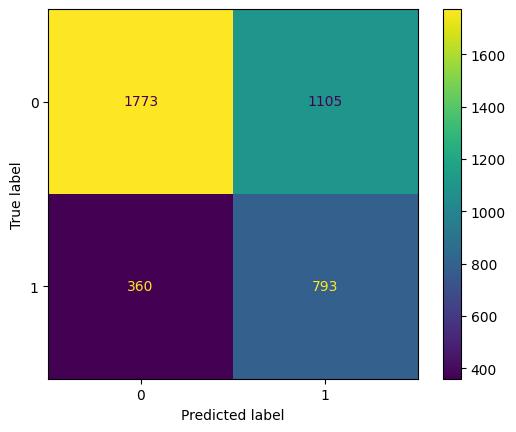

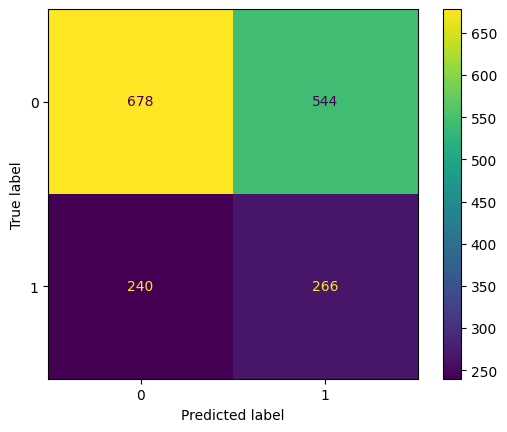

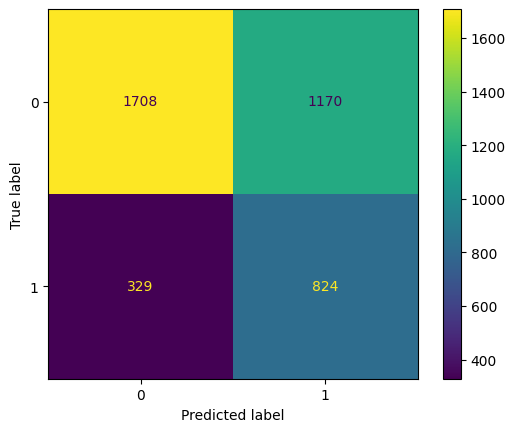

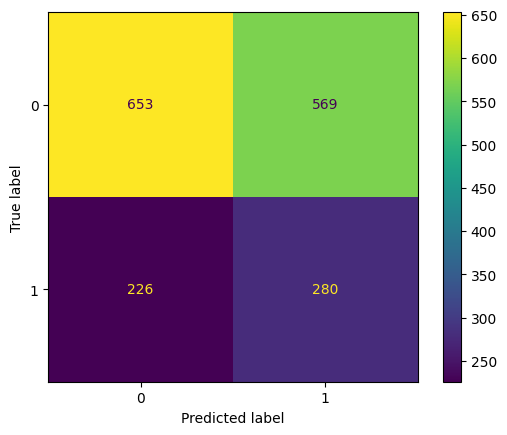

In [66]:
# 베스트 모델 평가 (Train/Test) + 임계값 튜닝 옵션
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score, f1_score, fbeta_score, precision_recall_curve, ConfusionMatrixDisplay
import os
OUTPUT_DIR = 'ML/outputs/01_XGBoost'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) 기본 임계값 평가
threshold = 0.5
y_proba_train_gs = best_model.predict_proba(X_train)[:,1]
y_proba_test_gs = best_model.predict_proba(X_test)[:,1]
y_pred_train_gs = (y_proba_train_gs >= threshold).astype(int)
y_pred_test_gs = (y_proba_test_gs >= threshold).astype(int)
print(f'Decision threshold: {threshold:.2f}')
print('='*5+'Train (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_train, y_pred_train_gs):.4f}')
print('Confusion Matrix')
cm_tr = confusion_matrix(y_train, y_pred_train_gs)
print(cm_tr)
print(classification_report(y_train, y_pred_train_gs))
print(f'ROC-AUC : {roc_auc_score(y_train, y_proba_train_gs):.4f}')
print(f'PR-AUC  : {average_precision_score(y_train, y_proba_train_gs):.4f}')
print('='*5+'Test (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_test, y_pred_test_gs):.4f}')
print('Confusion Matrix')
cm_te = confusion_matrix(y_test, y_pred_test_gs)
print(cm_te)
print(classification_report(y_test, y_pred_test_gs))
print(f'ROC-AUC : {roc_auc_score(y_test, y_proba_test_gs):.4f}')
print(f'PR-AUC  : {average_precision_score(y_test, y_proba_test_gs):.4f}')
# 혼동행렬 저장 (기본 임계값)
disp_tr = ConfusionMatrixDisplay(cm_tr)
disp_te = ConfusionMatrixDisplay(cm_te)
fig1 = disp_tr.plot(values_format='d').figure_
fig1.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_train.png'), dpi=150, bbox_inches='tight')
fig2 = disp_te.plot(values_format='d').figure_
fig2.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')

# 2) 임계값 튜닝 (훈련 세트 기반)
tuned_threshold = None
if 'THRESHOLD_TUNING' in globals() and THRESHOLD_TUNING != 'none':
    if THRESHOLD_TUNING == 'f1':
        best_f1, best_t = -1, 0.5
        for t in [i/200 for i in range(1,200)]:
            pred = (y_proba_train_gs >= t).astype(int)
            f1 = f1_score(y_train, pred)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        tuned_threshold = best_t
    elif THRESHOLD_TUNING == 'f05':
        best_f, best_t = -1, 0.5
        for t in [i/200 for i in range(1,200)]:
            pred = (y_proba_train_gs >= t).astype(int)
            f = fbeta_score(y_train, pred, beta=0.5)
            if f > best_f:
                best_f, best_t = f, t
        tuned_threshold = best_t
    elif THRESHOLD_TUNING == 'precision_at':
        p, r, th = precision_recall_curve(y_train, y_proba_train_gs)
        target = float(TARGET_PRECISION) if 'TARGET_PRECISION' in globals() else 0.8
        cand = [t for pi, t in zip(p[1:], th) if pi >= target]
        tuned_threshold = float(min(cand)) if cand else 0.5

if tuned_threshold is not None:
    print(f'Tuned decision threshold: {tuned_threshold:.3f} (mode={THRESHOLD_TUNING})')
    y_pred_train_tuned = (y_proba_train_gs >= tuned_threshold).astype(int)
    y_pred_test_tuned = (y_proba_test_gs >= tuned_threshold).astype(int)
    print('='*5+'Train (Tuned)'+'='*70)
    print(f'Acc : {accuracy_score(y_train, y_pred_train_tuned):.4f}')
    print('Confusion Matrix')
    cm_tr_t = confusion_matrix(y_train, y_pred_train_tuned)
    print(cm_tr_t)
    print(classification_report(y_train, y_pred_train_tuned))
    print('='*5+'Test (Tuned)'+'='*70)
    print(f'Acc : {accuracy_score(y_test, y_pred_test_tuned):.4f}')
    print('Confusion Matrix')
    cm_te_t = confusion_matrix(y_test, y_pred_test_tuned)
    print(cm_te_t)
    print(classification_report(y_test, y_pred_test_tuned))
    # 저장
    disp_tr_t = ConfusionMatrixDisplay(cm_tr_t)
    disp_te_t = ConfusionMatrixDisplay(cm_te_t)
    fig3 = disp_tr_t.plot(values_format='d').figure_
    fig3.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_train_tuned.png'), dpi=150, bbox_inches='tight')
    fig4 = disp_te_t.plot(values_format='d').figure_
    fig4.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_tuned.png'), dpi=150, bbox_inches='tight')


In [67]:
# True positive rows (predict=1 & true=1)
import pandas as pd

y_pred_test_series = pd.Series(y_pred_test_gs, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test_gs, index=X_test.index, name='predicted_proba')
tp_mask = (y_test == 1) & (y_pred_test_series == 1)
tp_df = X_test.loc[tp_mask].copy()
tp_df['actual'] = y_test.loc[tp_mask]
tp_df['predicted'] = y_pred_test_series.loc[tp_mask]
tp_df['predicted_proba'] = y_proba_test_series.loc[tp_mask]
print(f'Total true positives in test set: {tp_df.shape[0]}')
tp_df.to_csv('TP_traveler.csv')

Total true positives in test set: 266


In [68]:
# True negative rows (predict=0 & true=0)
import pandas as pd

y_pred_test_series = pd.Series(y_pred_test_gs, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test_gs, index=X_test.index, name='predicted_proba')
tn_mask = (y_test == 0) & (y_pred_test_series == 0)
tn_df = X_test.loc[tn_mask].copy()
tn_df['actual'] = y_test.loc[tn_mask]
tn_df['predicted'] = y_pred_test_series.loc[tn_mask]
tn_df['predicted_proba'] = y_proba_test_series.loc[tn_mask]
print(f'Total true positives in test set: {tn_df.shape[0]}')
tn_df.to_csv('TN_traveler.csv')

Total true positives in test set: 678


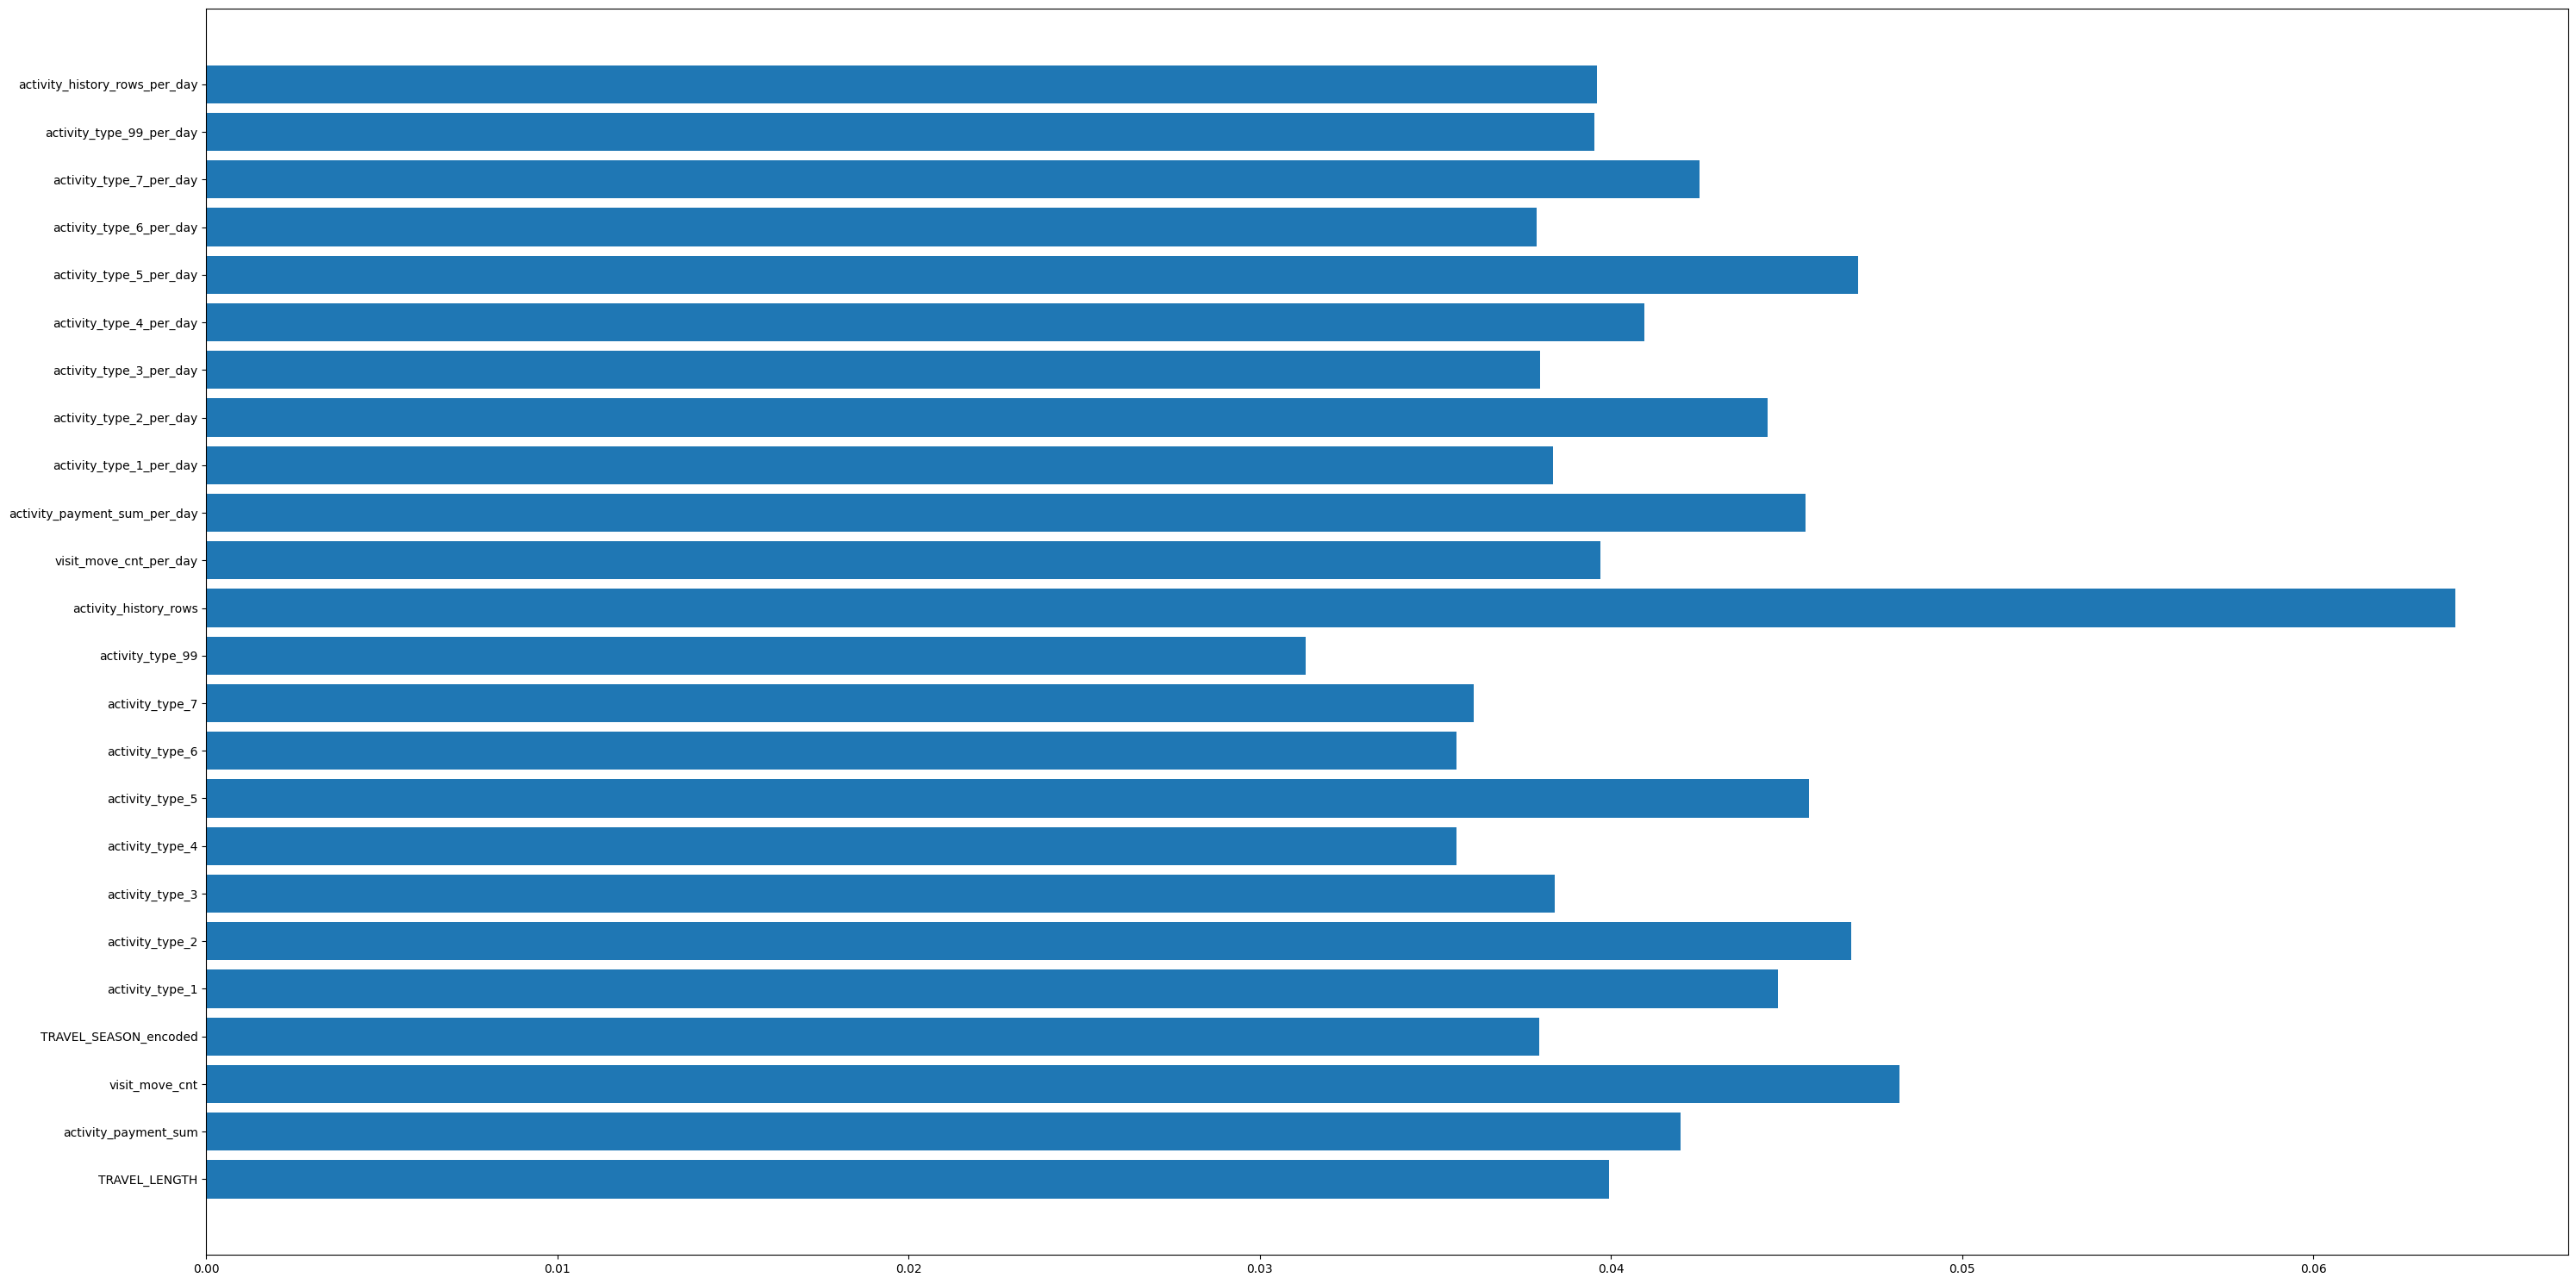

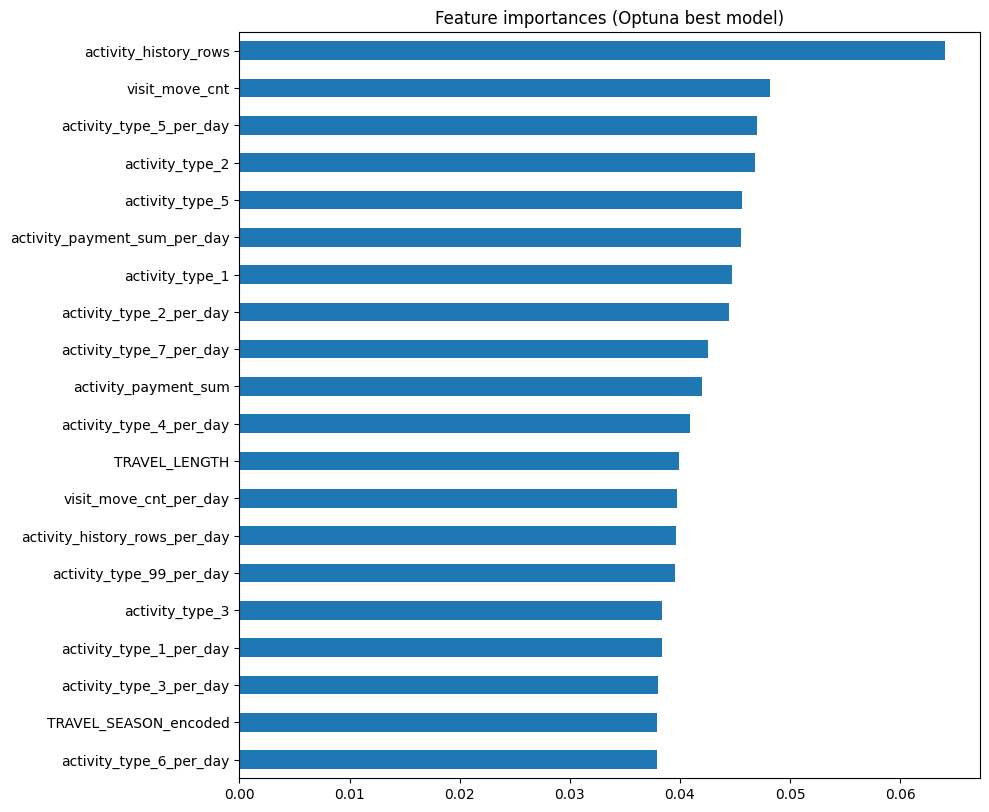

activity_history_rows            0.064056
visit_move_cnt                   0.048221
activity_type_5_per_day          0.047038
activity_type_2                  0.046838
activity_type_5                  0.045637
activity_payment_sum_per_day     0.045548
activity_type_1                  0.044752
activity_type_2_per_day          0.044463
activity_type_7_per_day          0.042532
activity_payment_sum             0.041992
activity_type_4_per_day          0.040954
TRAVEL_LENGTH                    0.039955
visit_move_cnt_per_day           0.039707
activity_history_rows_per_day    0.039611
activity_type_99_per_day         0.039520
activity_type_3                  0.038406
activity_type_1_per_day          0.038342
activity_type_3_per_day          0.037992
TRAVEL_SEASON_encoded            0.037954
activity_type_6_per_day          0.037886
activity_type_7                  0.036090
activity_type_4                  0.035603
activity_type_6                  0.035592
activity_type_99                 0

In [69]:
# 특성 중요도 (베스트 모델)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,15))
plt.barh(X.columns, best_model.feature_importances_)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importances.png'), dpi=150, bbox_inches='tight')
# 상위 20개만 저장 (가독성)
import numpy as np
imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,8))
imp.head(20)[::-1].plot(kind='barh')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importances_top.png'), dpi=150, bbox_inches='tight')
plt.title('Feature importances (Optuna best model)')
plt.show()

feat_imp = best_model.feature_importances_
feat_names = X_train.columns
feat_imp_ser = pd.Series(feat_imp, index=feat_names)

sorted_feature_importances = feat_imp_ser.sort_values(ascending=False)
print(sorted_feature_importances)

In [70]:
# True negative rows (predict=0 & true=0)
tn_mask = (y_test == 0) & (y_pred_test_series == 0)
tn_df = X_test.loc[tn_mask].copy()
tn_df['actual'] = y_test.loc[tn_mask]
tn_df['predicted'] = y_pred_test_series.loc[tn_mask]
tn_df['predicted_proba'] = y_proba_test_series.loc[tn_mask]
print(f'Total true negatives in test set: {tn_df.shape[0]}')
tn_df

Total true negatives in test set: 678


,TRAVEL_LENGTH,activity_payment_sum,visit_move_cnt,TRAVEL_SEASON_encoded,activity_type_1,activity_type_2,activity_type_3,activity_type_4,activity_type_5,activity_type_6,...,activity_type_3_per_day,activity_type_4_per_day,activity_type_5_per_day,activity_type_6_per_day,activity_type_7_per_day,activity_type_99_per_day,activity_history_rows_per_day,actual,predicted,predicted_proba
3176,3,-0.183154,15,1,4,1,0,2,1,1,...,0.000000,0.666667,0.333333,0.333333,0.666667,1.0,4.666667,0,0,0.451386
3768,2,0.062450,8,1,3,2,0,0,0,1,...,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,3.000000,0,0,0.477899
3196,3,0.422668,12,2,1,3,1,1,1,0,...,0.333333,0.333333,0.333333,0.000000,0.666667,0.0,3.000000,0,0,0.473035
4357,2,0.049351,5,1,1,2,0,1,0,0,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,2.000000,0,0,0.478365
132,2,-0.215901,8,2,1,1,1,0,0,0,...,0.500000,0.000000,0.000000,0.000000,1.000000,0.0,2.500000,0,0,0.484122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,2,-0.346889,7,0,3,1,1,2,1,0,...,0.500000,1.000000,0.500000,0.000000,0.000000,0.0,4.000000,0,0,0.465253
2723,2,0.072274,9,2,4,1,1,1,0,0,...,0.500000,0.500000,0.000000,0.000000,1.000000,0.0,4.500000,0,0,0.475943
3469,3,0.062450,13,0,8,1,1,2,2,0,...,0.333333,0.666667,0.666667,0.000000,0.666667,0.0,5.333333,0,0,0.424153
3877,3,0.232735,15,1,4,3,7,3,1,0,...,2.333333,1.000000,0.333333,0.000000,0.000000,0.0,6.000000,0,0,0.362075
